In [ ]:
#Import essential packages
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

import time

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model, Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dropout, LeakyReLU, Input, RepeatVector

# !pip install visualkeras
# import visualkeras

In [ ]:
# Connect to personnal google account
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Check the GPU given by Colab. Tesla P100-PCIE-16GB is the best. If different one assigned shut down the kernel and restart it.
!nvidia-smi -L

# Useful functions

In [ ]:
# Function we use for plotting
# Function we use for plotting
def plot_data_img(nr, nc, data, true_data, ts, title='Plot test', name_file=None, threshold=0.01):
  '''
  Function to plot the maps of the variables
  nr : number of plot row - int
  nc : number of plot column - int
  true_data : the original data - numpy array
  ts :  indices of the maps to plot - list
  title : title of the maps plotted - string
  name_file : name to save the plot as images. - string
  threshold : value added to the array to avoid nan values when converting to logarithmic scale - int
  '''
  #The min and max value of the oiginal data are saved to have the same colorbar when plotting the maps. 
  valmin = [np.min(true_data[elem]) for elem in ts]
  valmax = [np.max(true_data[elem]) for elem in ts] 
  
  fig, axes = plt.subplots(nr, nc, figsize=(20, 13))
  for t, ax, vmin, vmax in zip(ts, axes.ravel(), valmin, valmax):
    #Flip the image to see in the proper orientation
    rotate_image = ndimage.rotate(np.log(data[t]+threshold), 180)
    #Show the map with the threshold added.
    im = ax.imshow(rotate_image, vmin=np.log(vmin+threshold), vmax=np.log(vmax+threshold))
    ax.set_title(title + f" {t}")
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    #displaying the colorbar and adjusting its size
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.03)
    #Adjust maps size to avoid overlapping 
    fig.tight_layout(pad=1.5)
  
  #The image is saved only if a name_file is given to the function
  if name_file != None:
    #Adjust the size of the image to reduce white space aroung the image
    fig.set_size_inches(15,2.5)
    plt.savefig("/content/drive/MyDrive/Wildfires_IRP/Figures/"+name_file)

  plt.show()

def plot_data_img_diff(nr, nc, data1, data2, ts, title='Plot test', name_file=None):
  '''
  Function to plot the difference between original maps and maps predicted by the models
  nr : number of plot row - int
  nc : number of plot column - int
  data1 : the original data - numpy array
  data2 : predictions - numpy array
  ts :  indices of the maps to plot - list
  title : title of the maps plotted - string
  name_file : name to save the plot as images. - string
  '''
  fig, axes = plt.subplots(nr, nc, figsize=(20, 13))
  for t, ax in zip(ts, axes.ravel()):
    #Flip the image to see in the proper orientation
    rotate_image = ndimage.rotate(data2[t] - data1[t], 180)
    #Show the map with the threshold in a gray scale.
    im = ax.imshow(rotate_image, cmap='gray')
    ax.set_title(title + f" {t}")
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    #displaying the colorbar and adjusting its size
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.03)
    #Adjust maps size to avoid overlapping 
    fig.tight_layout(pad=1.5)
  
  #The image is saved only if a name_file is given to the function
  if name_file != None:
    #Adjust the size of the image to reduce white space aroung the image
    fig.set_size_inches(15,2.5) # this is use to when save the figures to avoid white space above and under
    plt.savefig("/content/drive/MyDrive/Wildfires_IRP/Figures/"+name_file, dpi=300)

  plt.show()

def Select_d_previous_month(d, data):
  '''
  Function that re organized the original data into array of d consecutive previous months 
  d : target number of consecutive month to consider - int 
  data : original data - numpy array

  returns :
  x_data : array of sequences containing d previous months, meaning shape of (d, ...) 
  y_data : array of sequences containing futur months, meaning shape of (1, ...)
  '''
  # set the number of previous month you want to take
  nl = [data[val:val+d] for val in range(0,len(data)-d)]
  x_data = np.asarray(nl)

  y_data = data[d:]

  return x_data, y_data

def Select_previous_future_months(d_previous_months, n_futur_months, data):
  '''
  Function that re organized the original data into array of d consecutive previous months and n consecutive futur months
  d_previous_months : target number of consecutive month to consider - int
  n_futur_months : target number of consecutive month to consider - int 
  data : original data - numpy array

  returns :
  x_data : array of sequences containing d previous months, meaning shape of (d_previous_months, ...) 
  y_data : array of sequences containing n futur months, meaning shape of (n_futur_months, ...) 
  '''
  # set the number of previous month you want to take
  nl = [data[val:val+d_previous_months] for val in range(0,len(data)+1 - d_previous_months - n_futur_months)]
  x_data = np.asarray(nl)

  fl = [data[elem:elem+n_futur_months] for elem in range(d_previous_months,len(data) + 1 -n_futur_months)]
  y_data =  np.asarray(fl)

  return x_data, y_data

def LSTM_mod(nsteps, data, summary=False):
  '''
  Function to build a LSTM model whith a One-by-One predictions. It takes compressed sequences of previous forecasts by CAE. And predict one by one the next forecast of area burnt.
  This corressponds to Many to one srategy.

  nsteps : the number of previous months takes into consideration - int
  data : array of data of shape (..., nsteps, 60) for joint models and (..., nsteps, 15) for single models - numpy arrays
  summary : to print the summary of the model - bool

  return :
  model : the built model not trained - keras object
  '''
  n_steps = nsteps
  n_features = data.shape[1]

  # define model
  model = Sequential()
  model.add(LSTM(450, activation='relu', return_sequences=True,
                 input_shape=(n_steps, n_features)))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2))
  model.add(LSTM(150, activation='relu'))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2))
  model.add(Dense(n_features))
  if summary is not False :
    model.summary()

  return model

def LSTM_MM(nsteps, n_future, data, summary=False):
  '''
  Function to build a LSTM model whith a Many-to-Many predictions strategy. It takes compressed sequences of previous forecasts by CAE. And predict sequences of the next forecast of area burnt.
  This corressponds to Many to Many srategy.
  This will take sequences of shape (..., nsteps, 60) for joint models and (..., nsteps, 15) for single models and will predict sequences of shape (..., nfuture, 60) for joint models and (..., nfuture, 15) for single models

  nsteps : the number of previous months takes into consideration - int
  data : arrays of data of shape (..., nsteps, 60) for joint models and (..., nsteps, 15) for single models
  summary : to print the summary of the model - bool

  return :
  model : the built model not trained - keras object
  '''
  n_steps = nsteps
  n_features = data.shape[1]

  model = Sequential()

  # encoder layer
  model.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2))

  model.add(LSTM(256, activation='relu'))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2))

  # repeat vector
  # Copy and shift the maps by n_future steps
  #For example if n_future = 3 the vectors are shifted by 3 so that the target output/maps of the current map is the next 3rd.  
  model.add(RepeatVector(n_future))

  # decoder layer
  model.add(LSTM(150, activation='relu', return_sequences=True))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2))

  model.add(TimeDistributed(Dense(n_features)))

  if summary is not False :
    model.summary()

  return model

# Import the scaled data

In [ ]:
#saving the reshaped scaled images
data_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_dta_p1_scaled.npy")
data_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_dta_p2_scaled.npy")
data_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_dta_p3_scaled.npy")

In [ ]:
print("Shape of P1 : ", data_p1.shape)
print("Shape of P2 : ", data_p2.shape)
print("Shape of P3 : ", data_p3.shape)

Shape of P1 :  (360, 112, 192)
Shape of P2 :  (360, 112, 192)
Shape of P3 :  (360, 112, 192)


# Import the compressor

In [ ]:
# Load compressor
conv_ae = load_model('/content/drive/MyDrive/Wildfires_IRP/compressors/CAE_areaburnt')

In [ ]:
encoder = conv_ae.get_layer(index=0)
decoder = conv_ae.get_layer(index=1)

# Compress the data

In [ ]:
p1_training_comp = encoder.predict(data_p1)
print("Shape of the p1 training set after compression by the CAE: ", p1_training_comp.shape)

p2_training_comp = encoder.predict(data_p2)
print("Shape of the p1 training set after compression by the CAE: ", p2_training_comp.shape)

p3_training_comp = encoder.predict(data_p3)
print("Shape of the p3 trainingset after compression by the CAE: ", p3_training_comp.shape)

Shape of the p1 training set after compression by the CAE:  (360, 15)
Shape of the p1 training set after compression by the CAE:  (360, 15)
Shape of the p3 trainingset after compression by the CAE:  (360, 15)


# Multiple -> One

#### Process the training set for training model as multiple to one

##### Which means we process the training set so that it will be of the form :
```
xarray = [[month1, month2], [month2, month3], [month3, month4], ...]
yarray = [month3, month4, month5, ...]
```

In [ ]:
#3 months
X_train3to1_p1, Y_train3to1_p1 = Select_d_previous_month(d=3, data=p1_training_comp)
X_train3to1_p2, Y_train3to1_p2 = Select_d_previous_month(d=3, data=p2_training_comp)
X_train3to1_p3, Y_train3to1_p3 = Select_d_previous_month(d=3, data=p3_training_comp)

X_train3to1 = np.concatenate([X_train3to1_p1, X_train3to1_p2, X_train3to1_p3], axis=0)
Y_train3to1 = np.concatenate([Y_train3to1_p1, Y_train3to1_p2, Y_train3to1_p3], axis=0)

#6 months
X_train6to1_p1, Y_train6to1_p1 = Select_d_previous_month(d=6, data=p1_training_comp)
X_train6to1_p2, Y_train6to1_p2 = Select_d_previous_month(d=6, data=p2_training_comp)
X_train6to1_p3, Y_train6to1_p3 = Select_d_previous_month(d=6, data=p3_training_comp)

X_train6to1 = np.concatenate([X_train6to1_p1, X_train6to1_p2, X_train6to1_p3], axis=0)
Y_train6to1 = np.concatenate([Y_train6to1_p1, Y_train6to1_p2, Y_train6to1_p3], axis=0)

#A year
X_train12to1_p1, Y_train12to1_p1 = Select_d_previous_month(d=12, data=p1_training_comp)
X_train12to1_p2, Y_train12to1_p2 = Select_d_previous_month(d=12, data=p2_training_comp)
X_train12to1_p3, Y_train12to1_p3 = Select_d_previous_month(d=12, data=p3_training_comp)

X_train12to1 = np.concatenate([X_train12to1_p1, X_train12to1_p2, X_train12to1_p3], axis=0)
Y_train12to1 = np.concatenate([Y_train12to1_p1, Y_train12to1_p2, Y_train12to1_p3], axis=0)

In [ ]:
print("Shape of training set for 3 previous month : ", X_train3to1.shape, " and the one of its response : ", Y_train3to1.shape)
print("Shape of training set for 6 previous month : ", X_train6to1.shape, " and the one of its response : ", Y_train6to1.shape)
print("Shape of training set for 12 previous month : ", X_train12to1.shape, " and the one of its response : ", Y_train12to1.shape)

Shape of training set for 3 previous month :  (1071, 3, 15)  and the one of its response :  (1071, 15)
Shape of training set for 6 previous month :  (1062, 6, 15)  and the one of its response :  (1062, 15)
Shape of training set for 12 previous month :  (1044, 12, 15)  and the one of its response :  (1044, 15)


#### LSTM model 12 -> 1

In [ ]:
#Build the callbacks which will stops the model in case of overfitting.
#Training is stop if validation loss doesn't improve for 50 epochs.
#Therefore the best weights so far are restored
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)
#Reduce plateau helsp the optimizer convergence when val loss is not improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)

#Model building calling the functions and compiling
mod_12d = LSTM_mod(nsteps=12, data=p1_training_comp, summary=True)
mod_12d.compile(optimizer='adam', loss='mse', metrics=['mse'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 12, 450)           838800    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 12, 450)           0         
                                                                 
 dropout_7 (Dropout)         (None, 12, 450)           0         
                                                                 
 lstm_8 (LSTM)               (None, 150)               360600    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 150)               0         
                                                                 
 dropout_8 (Dropout)         (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 15)               

In [ ]:
train12d, val_12d, ytrain12d, yval12d = train_test_split(X_train12to1, Y_train12to1, test_size=0.15, random_state=123)

In [ ]:
start = time.time()
history = mod_12d.fit(train12d, ytrain12d, validation_split=0.15, shuffle=True,
                    epochs=1000,
                    verbose=0,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Restoring model weights from the end of the best epoch: 298.
Epoch 348: early stopping


______________ Loss plot of CAE + LSTM with 12 months as inputs__________________



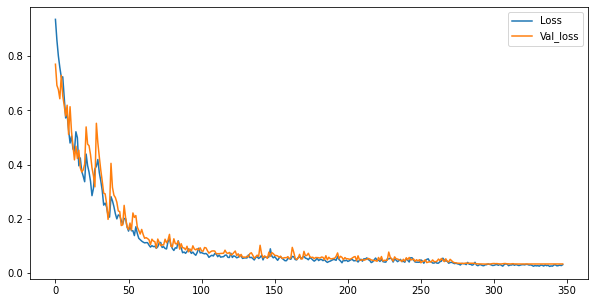

In [ ]:
print("______________ Loss plot of CAE + LSTM with 12 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
#Models best score
print("Best score : ", mod_12d.evaluate(train12d, ytrain12d, verbose=0))

Best score :  [0.008741107769310474, 0.008741107769310474]


In [ ]:
#Predict on validation set
predictions = mod_12d.predict(val_12d)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval12d.shape)

Shape of the predictions set:  (152, 15)
Shape of the original test set:  (152, 15)


In [ ]:
#Displaying performance of the model on validation set and training set
pred_train = mod_12d.predict(train12d)

relative_mse_train_nw =[np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train,ytrain12d)]
relative_mse_train_ow = np.linalg.norm(ytrain12d - pred_train) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain12d.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round( 353.527456, 2), 's')

relative_mse_test_nw =[np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(predictions,yval12d)]
relative_mse_test_ow = np.linalg.norm(yval12d - predictions) / (112*192)
mse_test = mean_squared_error(predictions.ravel(),yval12d.ravel())
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))

___________Training set predictions______________
mse for train dataset:  1.2001284934688668e-05

 Time to train AE:  353.53 s

___________Testing set predictions______________
mse for test dataset:  2.0756854961259628e-05


In [ ]:
results_LSTM_12to1 = {'Time for training (s)': 353.527456, 
           'relative mse_test':  np.mean(relative_mse_test_nw), 
           'relative mse_train': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  np.mean(relative_mse_test_nw), 
           'relative mse_train old way': np.mean(relative_mse_train_nw),#
           'mse test':  mse_test, 
           'mse train': mse_train,
          }

In [ ]:
# Saving the model
mod_12d.save('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_12to1.h5')

# Load model
#mod_12d = load_model('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_12to1.h5')

# Multiple -> Multiple

#### Process the training set for training model as multiple to one

##### Which means we process the training set so that it will be of the form :
```
xarray = [[month1, month2], [month2, month3], [month3, month4], ...]
yarray = [[month3, month4], [month4, month5], [month5, month6], ...]
```

In [ ]:
#try for 3 months
X_train3to3_p1, Y_train3to3_p1 = Select_previous_future_months(d_previous_months=3, n_futur_months=3, data=p1_training_comp)
X_train3to3_p2, Y_train3to3_p2 = Select_previous_future_months(d_previous_months=3, n_futur_months=3, data=p2_training_comp)
X_train3to3_p3, Y_train3to3_p3 = Select_previous_future_months(d_previous_months=3, n_futur_months=3, data=p3_training_comp)

X_train3to3 = np.concatenate([X_train3to3_p1, X_train3to3_p2, X_train3to3_p3], axis=0)
Y_train3to3 = np.concatenate([Y_train3to3_p1, Y_train3to3_p2, Y_train3to3_p3], axis=0)

#try for 6 months
X_train6to6_p1, Y_train6to6_p1 = Select_previous_future_months(d_previous_months=6, n_futur_months=6, data=p1_training_comp)
X_train6to6_p2, Y_train6to6_p2 = Select_previous_future_months(d_previous_months=6, n_futur_months=6, data=p2_training_comp)
X_train6to6_p3, Y_train6to6_p3 = Select_previous_future_months(d_previous_months=6, n_futur_months=6, data=p3_training_comp)

X_train6to6 = np.concatenate([X_train6to6_p1, X_train6to6_p2, X_train6to6_p3], axis=0)
Y_train6to6 = np.concatenate([Y_train6to6_p1, Y_train6to6_p2, Y_train6to6_p3], axis=0)

#try for a year
X_train12to12_p1, Y_train12to12_p1 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=p1_training_comp)
X_train12to12_p2, Y_train12to12_p2 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=p2_training_comp)
X_train12to12_p3, Y_train12to12_p3 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=p3_training_comp)

X_train12to12 = np.concatenate([X_train12to12_p1, X_train12to12_p2, X_train12to12_p3], axis=0)
Y_train12to12 = np.concatenate([Y_train12to12_p1, Y_train12to12_p2, Y_train12to12_p3], axis=0)

In [ ]:
print("Shape of training set for 3 previous month : ", X_train3to3.shape, " and the one of its response : ", Y_train3to3.shape)
print("Shape of training set for 6 previous month : ", X_train6to6.shape, " and the one of its response : ", Y_train6to6.shape)
print("Shape of training set for 12 previous month : ", X_train12to12.shape, " and the one of its response : ", Y_train12to12.shape)

Shape of training set for 3 previous month :  (1065, 3, 15)  and the one of its response :  (1065, 3, 15)
Shape of training set for 6 previous month :  (1047, 6, 15)  and the one of its response :  (1047, 6, 15)
Shape of training set for 12 previous month :  (1011, 12, 15)  and the one of its response :  (1011, 12, 15)


#### LSTM model 12 -> 12

In [ ]:
#Build the callbacks which will stops the model in case of overfitting.
#Training is stop if validation loss doesn't improve for 50 epochs.
#Therefore the best weights so far are restored
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)
#Reduce plateau helsp the optimizer convergence when val loss is not improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)
#Model building calling the functions for M2M LSTm models
mod_12d_12f = LSTM_MM(nsteps=12, n_future=12, data=p1_training_comp, summary=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 512)           1081344   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 12, 512)           0         
                                                                 
 dropout_4 (Dropout)         (None, 12, 512)           0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               787456    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 12, 256)         

In [ ]:
train12d, val_12d, ytrain12d, yval12d = train_test_split(X_train12to12, Y_train12to12, test_size=0.15, random_state=123)

In [ ]:
mod_12d_12f.compile(optimizer='adam', loss='mse')

start = time.time()
history = mod_12d_12f.fit(train12d, ytrain12d, validation_split=0.15, shuffle=True,
                    epochs=1000,
                    verbose=0,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Restoring model weights from the end of the best epoch: 304.
Epoch 354: early stopping


______________ Loss plot of CAE + LSTM with 12 months as inputs and 12 as outputs__________________



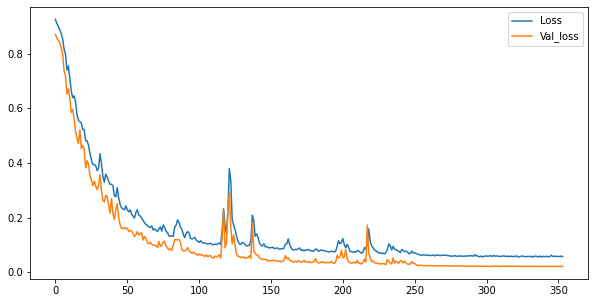

In [ ]:
print("______________ Loss plot of CAE + LSTM with 12 months as inputs and 12 as outputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
print("Best score : ", mod_12d_12f.evaluate(train12d, ytrain12d, verbose=0))

Best score :  0.017435355111956596


In [ ]:
predictions = mod_12d_12f.predict(val_12d)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval12d.shape)

Shape of the predictions set:  (152, 12, 15)
Shape of the original test set:  (152, 12, 15)


In [ ]:
pred_train = mod_12d_12f.predict(train12d)

relative_mse_train_nw =[np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train,ytrain12d)]
relative_mse_train_ow = np.linalg.norm(ytrain12d - pred_train) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain12d.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round(839.78, 2), 's')

relative_mse_test_nw =[np.linalg.norm(elem - elem2) / (112*192) for elem, elem2 in zip(predictions,yval12d)]
relative_mse_test_ow = np.linalg.norm(yval12d - predictions) / (112*192)
mse_test = mean_squared_error(predictions.ravel(), yval12d.ravel())
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))

___________Training set predictions______________
mse for train dataset:  8.002249517543771e-05

 Time to train AE:  839.78 s

___________Testing set predictions______________
mse for test dataset:  9.172279210463587e-05


In [ ]:
results_LSTM_12to12 = {'Time for training (s)':   839.78, 
           'relative mse_test':  np.mean(relative_mse_test_nw), 
           'relative mse_train': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  np.mean(relative_mse_test_ow), 
           'relative mse_train old way': np.mean(relative_mse_train_ow),#
           'mse_test':  mse_test, 
           'mse_train': mse_train,
          }

In [ ]:
# Saving the model
mod_12d_12f.save('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_12to12.h5')

# Load model
#mod_12d_12f = load_model('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_12to12.h5')

# Comparison of training results - Table

*The results of 3 to 3, 6 to 6, 3 to 1, 6 to 1 are extracted from appendix.*

In [ ]:
pd.set_option('display.float_format', '{:.2e}'.format)

print("______________Results Many - to - One_____________________\n\n")
pd.DataFrame([results_LSTM_3to1, results_LSTM_6to1, results_LSTM_12to1],
             index=['CAE LSTM - 3 to 1', 'CAE LSTM - 6 to 1', 'CAE LSTM - 12 to 1']
             ).sort_values('relative mse_test')

______________Results Many - to - One_____________________




,Time for training (s),relative mse_test,relative mse_train,relative mse_test old way,relative mse_train old way,mse train,mse test
CAE LSTM - 12 to 1,3.54e+02,1.93e-05,1.37e-05,1.93e-05,1.37e-05,1.23e-02,2.86e-02
CAE LSTM - 6 to 1,2.19e+02,2.48e-05,1.38e-05,2.48e-05,1.38e-05,8.96e-03,4.78e-02
CAE LSTM - 3 to 1,1.72e+02,2.54e-05,1.62e-05,4.12e-04,5.05e-04,1.04e-02,3.90e-02


In [ ]:
print("______________Results MAny - to - Many_____________________\n\n")
pd.DataFrame([results_LSTM_3to3, results_LSTM_6to6, results_LSTM_12to12],
             index=['CAE LSTM - 3 to 3', 'CAE LSTM - 6 to 6', 'CAE LSTM - 12 to 12']
             ).sort_values('relative mse_test')

______________Results MAny - to - Many_____________________




,Time for training (s),relative mse_test,relative mse_train,relative mse_test old way,relative mse_train old way,mse_test,mse_train
CAE LSTM - 3 to 3,4.82e+02,5.43e-05,3.03e-05,1.02e-03,1.11e-03,7.98e-02,1.67e-02
CAE LSTM - 6 to 6,4.22e+02,6.32e-05,5.26e-05,7.92e-04,1.50e-03,2.46e-02,1.57e-02
CAE LSTM - 12 to 12,8.40e+02,9.44e-05,8.18e-05,1.11e-03,2.23e-03,2.52e-02,1.80e-02


# Comparison of the model through iterative predictions on p3

### 12 to 1

In [ ]:
#Predictions
area_training_comp_p3 = encoder.predict(p3_training_set)

pred_M21 = list(area_training_comp_p3[-12:])

for i in range(0,60):
  pred_M21.append(mod_3d.predict(np.reshape(pred_M21[-12:], newshape=(1,12,15)))[0])

fpred_M21= decoder.predict(np.asarray(pred_M21))
fpredM21 = np.squeeze(fpred_M21)[12:72]

In [ ]:
#Computing the metrics
relative_mse_CAE_LSTM_M21_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(fpredM21, p3_testing_set)]
mse_CAE_LSTM_M21 = mean_squared_error(fpredM21.ravel(), p3_testing_set.ravel())
relative_mse_CAE_LSTM_M21_ow = np.linalg.norm(p3_testing_set - fpredM21) / (112*192)

rmse12to1 = np.cumsum(relative_mse_CAE_LSTM_M21_nw)
mse12to1 = np.cumsum([mean_squared_error(elem, elem2) for elem, elem2 in zip(fpredM21, p3_testing_set)])

In [ ]:
results_CAE_LSTM_3to1 = {'Time for predictions (s)': round(end - start, 3), 
           'relative mse new way':  np.mean(relative_mse_CAE_LSTM_M21_nw),
           'relative mse old way':  relative_mse_CAE_LSTM_M21_ow,
           'mse_test' : mse_CAE_LSTM_M21
          }

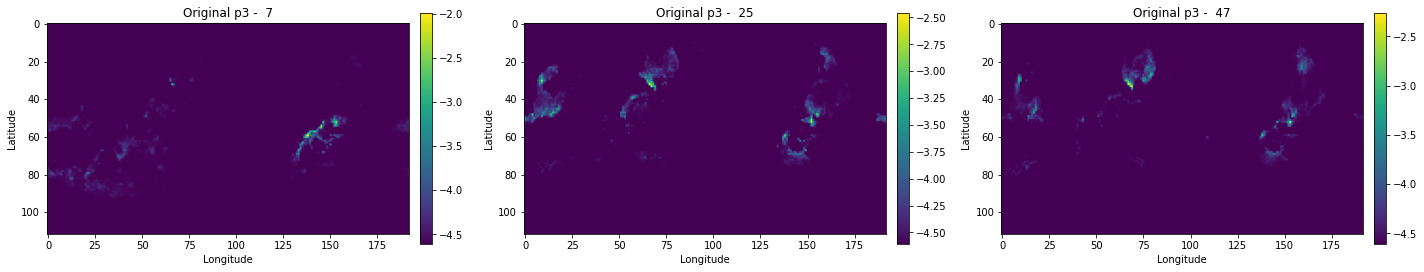

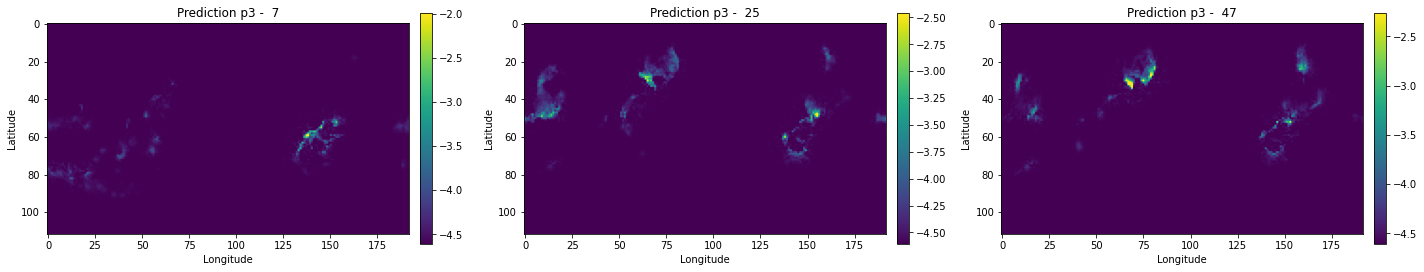

In [ ]:
plot_data_img(1, 3, data = p3_testing_set, true_data=p3_testing_set, ts=[7, 25, 47], title='Original p3 - ')
plot_data_img(1, 3, data = fpredM21, true_data=p3_testing_set, ts=[7, 25, 47], title='Prediction p3 - ')

### 12 to 12

In [ ]:
pred_M2M = list(area_training_comp_p3[-12:])

while len(pred_M2M) < 72 :
  
  pred1 = mod_12d_12f.predict(np.reshape(pred_M2M[-12:], newshape=(1,12,15)))[0]
  for i in range(12):
    pred_M2M.append(pred1[i])

fpred_M2M = decoder.predict(np.asarray(pred_M2M))
fpredM2M = np.squeeze(fpred_M2M)[12:72]

In [ ]:
relative_mse_CAE_LSTM_12to12_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(fpredM2M, p3_testing_set)]
mse_CAE_LSTM_12to12 = mean_squared_error(fpredM2M.ravel(), p3_testing_set.ravel())
relative_mse_CAE_LSTM_12to12_ow = np.linalg.norm(p3_testing_set - fpredM2M) / (112*192)

rmse12to12 = np.cumsum(relative_mse_CAE_LSTM_12to12_nw)
mse12to12 = np.cumsum([mean_squared_error(elem2, elem) for elem, elem2 in zip(fpredM2M, p3_testing_set)])

In [ ]:
results_CAE_LSTM_12to12 = {'Time for predictions (s)': round(end - start, 3), 
           'relative mse new way':  np.mean(relative_mse_CAE_LSTM_12to12_nw),
           'relative mse old way':  relative_mse_CAE_LSTM_12to12_ow,
           'mse_test': mse_CAE_LSTM_12to12
          }

____________ Real images ________________


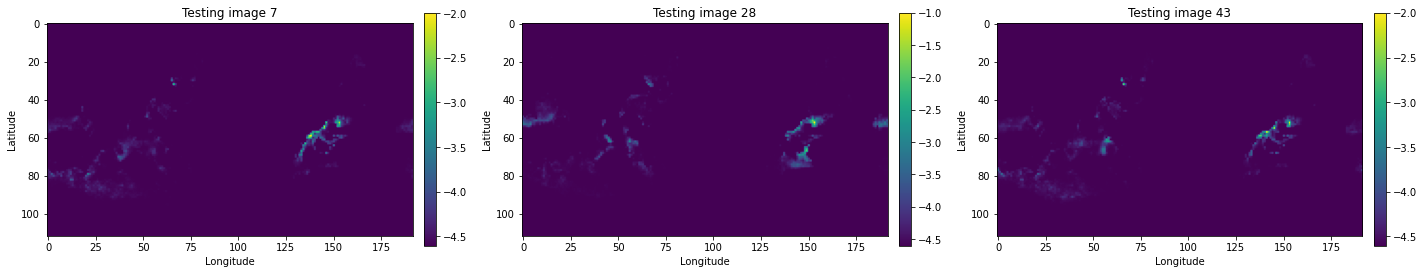

____________ Predictions 12 to 12 _____________ 


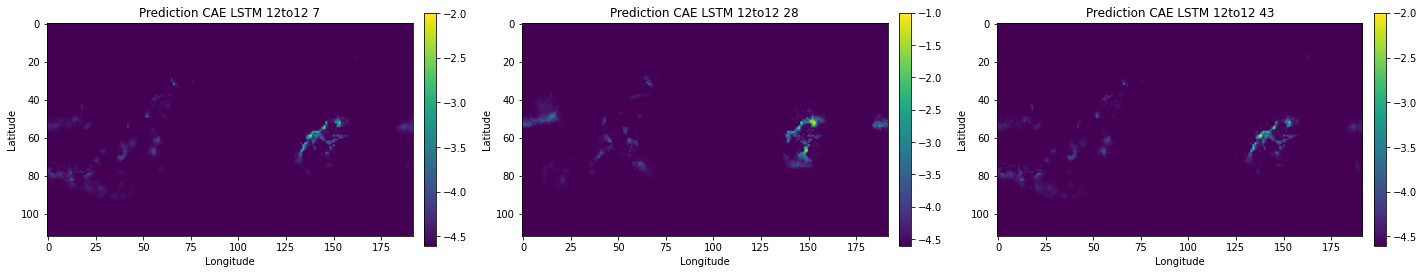

In [ ]:
#Plot 6 to 1 
print("____________ Real images ________________")
plot_data_img(1, 3, data = p3_testing_set, true_data=p3_testing_set, ts=[7, 28, 43], title='Testing image')

print("____________ Predictions 12 to 12 _____________ ")
plot_data_img(1, 3, data = fpredM2M, true_data=p3_testing_set, ts = [7, 28, 43], title='Prediction CAE LSTM 12to12')

### Table of results

*The results of 3 to 3, 6 to 6, 3 to 1, 6 to 1 are extracted from appendix.*

In [ ]:
pd.DataFrame([results_CAE_LSTM_3to1, results_CAE_LSTM_6to1, results_CAE_LSTM_12to1],
             index=['CAE LSTM - 3 to 1', 'CAE LSTM - 6 to 1', 'CAE LSTM - 12 to 1']
             ).sort_values('relative mse new way')

,Time for predictions (s),mse_test,relative mse new way,relative mse old way
CAE LSTM - 3 to 1,4.41e+01,5.90e-06,1.51e-05,1.28e-04
CAE LSTM - 6 to 1,4.41e+01,5.98e-06,1.53e-05,1.29e-04
CAE LSTM - 12 to 1,4.41e+01,6.15e-06,1.54e-05,1.31e-04


In [ ]:
pd.DataFrame([results_CAE_LSTM_3to3, results_CAE_LSTM_6to6, results_CAE_LSTM_12to12],
             index=['CAE LSTM - 3 to 3', 'CAE LSTM - 6 to 6', 'CAE LSTM - 12 to 12']
             ).sort_values('relative mse new way')

,Time for predictions (s),mse_test,relative mse new way,relative mse old way
CAE LSTM - 3 to 3,4.41e+01,5.88e-06,1.52e-05,1.28e-04
CAE LSTM - 12 to 12,4.41e+01,6.66e-06,1.55e-05,1.36e-04
CAE LSTM - 6 to 6,4.41e+01,6.04e-06,1.55e-05,1.30e-04


# Appendix - Everything that has been also tried

#### LSTM model 3 -> 1

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)

mod_3d = LSTM_mod(nsteps=3, data=p1_training_comp, summary=True)

mod_3d.compile(optimizer='adam', loss='mse', metrics=['mse'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 3, 512)            1081344   
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 3, 512)            0         
                                                                 
 dropout_34 (Dropout)        (None, 3, 512)            0         
                                                                 
 lstm_35 (LSTM)              (None, 3, 256)            787456    
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 3, 256)            0         
                                                                 
 dropout_35 (Dropout)        (None, 3, 256)            0         
                                                                 
 lstm_36 (LSTM)              (None, 150)             

In [ ]:
train3d, val_3d, ytrain3d, yval3d = train_test_split(X_train3to1, Y_train3to1, test_size=0.15, random_state=123)

In [ ]:
start = time.time()
history = mod_3d.fit(train3d, ytrain3d, validation_split=0.15, shuffle=True,
                    epochs=1000,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Epoch 1/1000
21/21 [==============================] - 5s 64ms/step - loss: 1.0284 - mse: 1.0284 - val_loss: 1.1855 - val_mse: 1.1855 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - 1s 34ms/step - loss: 0.9560 - mse: 0.9560 - val_loss: 1.0871 - val_mse: 1.0871 - lr: 0.0010
Epoch 3/1000
21/21 [==============================] - 1s 34ms/step - loss: 0.8718 - mse: 0.8718 - val_loss: 0.9806 - val_mse: 0.9806 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - 1s 34ms/step - loss: 0.7992 - mse: 0.7992 - val_loss: 0.9281 - val_mse: 0.9281 - lr: 0.0010
Epoch 5/1000
21/21 [==============================] - 1s 33ms/step - loss: 0.7527 - mse: 0.7527 - val_loss: 0.7902 - val_mse: 0.7902 - lr: 0.0010
Epoch 6/1000
21/21 [==============================] - 1s 34ms/step - loss: 0.6667 - mse: 0.6667 - val_loss: 0.6943 - val_mse: 0.6943 - lr: 0.0010
Epoch 7/1000
21/21 [==============================] - 1s 36ms/step - loss: 0.6251 - mse: 0.6251 - val_loss: 0.6232 - val_mse

______________ Loss plot of CAE + LSTM with 3 months as inputs__________________



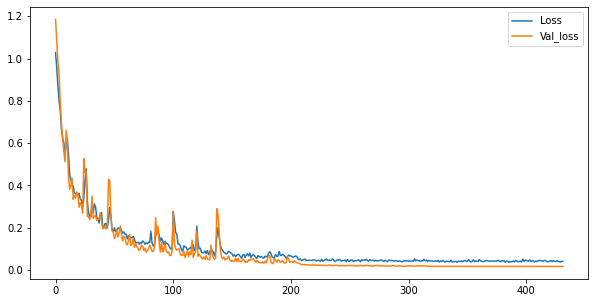

In [ ]:
print("______________ Loss plot of CAE + LSTM with 3 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
print("Best score : ", mod_3d.evaluate(train3d, ytrain3d, verbose=0))

Best score :  [0.011497275903820992, 0.011497275903820992]


In [ ]:
predictions = mod_3d.predict(val_3d)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval3d.shape)

Shape of the predictions set:  (134, 15)
Shape of the original test set:  (134, 15)


In [ ]:
pred_train = mod_3d.predict(train3d)

relative_mse_train_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train, ytrain3d)]
relative_mse_train_ow = np.linalg.norm(ytrain3d - pred_train) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain3d.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round(171.718567, 2), 's')

relative_mse_test_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(predictions, yval3d)]
relative_mse_test_ow = np.linalg.norm(yval3d - predictions) / (112*192)
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))
mse_test = mean_squared_error(predictions.ravel(), yval3d.ravel())

___________Training set predictions______________
mse for train dataset:  1.618999052585573e-05

 Time to train AE:  171.72 s

___________Testing set predictions______________
mse for test dataset:  2.541686586423214e-05


In [ ]:
results_LSTM_3to1 = {'Time for training (s)': 171.718567, 
           'relative mse_test':  np.mean(relative_mse_test_nw), 
           'relative mse_train': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  relative_mse_test_ow, 
           'relative mse_train old way': relative_mse_train_ow,
           'mse train' : mse_train,
           'mse test' : mse_test,
          }

In [ ]:
# Saving the model
#mod_3d.save('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_3to1.h5')

# Load model
mod_3d = load_model('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_3to1.h5')

#### LSTM model 6 -> 1

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

mod_6d = LSTM_mod(nsteps=6, data=p1_training_comp, summary=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)
mod_6d.compile(optimizer='adam', loss='mse', metrics=['mse'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 450)            838800    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6, 450)            0         
                                                                 
 dropout_2 (Dropout)         (None, 6, 450)            0         
                                                                 
 lstm_3 (LSTM)               (None, 150)               360600    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 150)               0         
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 15)               

In [ ]:
train6d, val_6d, ytrain6d, yval6d = train_test_split(X_train6to1, Y_train6to1, test_size=0.15, random_state=123)

In [ ]:
start = time.time()
history = mod_6d.fit(train6d, ytrain6d, validation_split=0.15, shuffle=True,
                    epochs=1000,
                    verbose=0,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Restoring model weights from the end of the best epoch: 246.
Epoch 296: early stopping


______________ Loss plot of CAE + LSTM with 6 months as inputs__________________



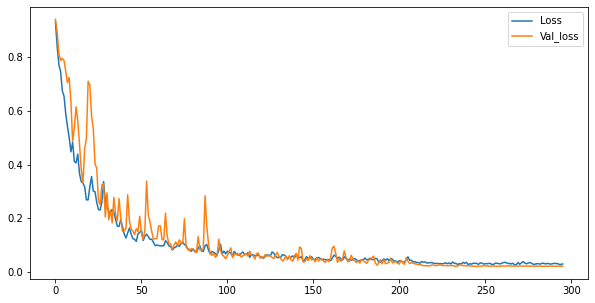

In [ ]:
print("______________ Loss plot of CAE + LSTM with 6 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
print("Best score : ", mod_6d.evaluate(train6d, ytrain6d, verbose=0))

Best score :  [0.00896141305565834, 0.00896141305565834]


In [ ]:
predictions = mod_6d.predict(val_6d)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval6d.shape)

Shape of the predictions set:  (133, 15)
Shape of the original test set:  (133, 15)


In [ ]:
pred_train = mod_6d.predict(train6d)

relative_mse_train_nw =[np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train, ytrain6d)]
relative_mse_train_ow =np.linalg.norm(ytrain6d - pred_train) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain6d.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round(218.743102, 2), 's')

relative_mse_test_ow = np.linalg.norm(yval6d - predictions) / (112*192)
relative_mse_test_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(predictions, yval6d)]
mse_test = mean_squared_error(predictions.ravel(), yval6d.ravel())
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))

___________Training set predictions______________
mse for train dataset:  1.3805806888888071e-05

 Time to train AE:  218.74 s

___________Testing set predictions______________
mse for test dataset:  2.4777219849999598e-05


In [ ]:
results_LSTM_6to1 = {'Time for training (s)': 218.743102, 
           'relative mse_test':  np.mean(relative_mse_test_nw), 
           'relative mse_train': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  np.mean(relative_mse_test_nw), 
           'relative mse_train old way': np.mean(relative_mse_train_nw),#
           'mse test':  mse_test, 
           'mse train': mse_train,
          }

In [ ]:
# Saving the model
# mod_6d.save('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_6to1.h5')
mod_6d = load_model('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_6to1.h5')

#### LSTM model 3 -> 3

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

mod_3d_3f = LSTM_MM(nsteps=3, n_future=3, data=p1_training_comp, summary=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=50)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 3, 512)            1081344   
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 3, 512)            0         
                                                                 
 dropout_22 (Dropout)        (None, 3, 512)            0         
                                                                 
 lstm_23 (LSTM)              (None, 256)               787456    
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 repeat_vector_5 (RepeatVect  (None, 3, 256)          

In [ ]:
train3d, val_3d, ytrain3d, yval3d = train_test_split(X_train3to3, Y_train3to3, test_size=0.15, random_state=123)

In [ ]:
mod_3d_3f.compile(optimizer='adam', loss='mse')
start = time.time()
history = mod_3d_3f.fit(train3d, ytrain3d, epochs=1000, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])
end = time.time()

Epoch 1/1000
19/19 [==============================] - 6s 66ms/step - loss: 1.0020 - val_loss: 0.9324 - lr: 0.0010
Epoch 2/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.9465 - val_loss: 0.8761 - lr: 0.0010
Epoch 3/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.9026 - val_loss: 0.8515 - lr: 0.0010
Epoch 4/1000
19/19 [==============================] - 1s 35ms/step - loss: 0.8666 - val_loss: 0.8155 - lr: 0.0010
Epoch 5/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.8327 - val_loss: 0.7810 - lr: 0.0010
Epoch 6/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.7990 - val_loss: 0.7605 - lr: 0.0010
Epoch 7/1000
19/19 [==============================] - 1s 36ms/step - loss: 0.7744 - val_loss: 0.7231 - lr: 0.0010
Epoch 8/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.7335 - val_loss: 0.7008 - lr: 0.0010
Epoch 9/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.7055 - val_

______________ Loss plot of LSTM with 3 months as inputs and3 as output__________________



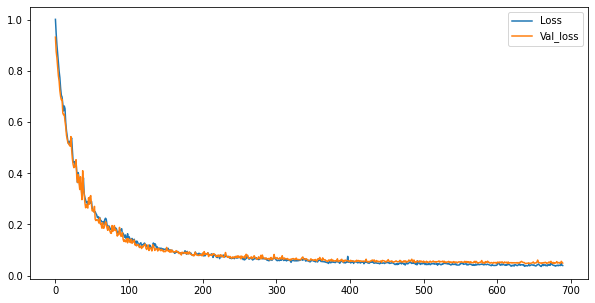

In [ ]:
print("______________ Loss plot of LSTM with 3 months as inputs and3 as output__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
print("Best score : ", mod_3d_3f.evaluate(train3d, ytrain3d, verbose=0))

Best score :  0.01673576608300209


In [ ]:
predictions = mod_3d_3f.predict(val_3d)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval3d.shape)

Shape of the predictions set:  (133, 3, 15)
Shape of the original test set:  (133, 3, 15)


In [ ]:
pred_train = mod_3d_3f.predict(train3d)

relative_mse_train_nw =[np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train,ytrain3d)]
relative_mse_train_ow = np.linalg.norm(ytrain3d - pred_train) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain3d.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round(481.92, 2), 's')

relative_mse_test_nw =[np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(predictions,yval3d)]
relative_mse_test_ow = np.linalg.norm(yval3d - predictions) / (112*192)
mse_test = mean_squared_error(predictions.ravel(), yval3d.ravel())
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))

___________Training set predictions______________
mse for train dataset:  3.0293100430887452e-05

 Time to train AE:  481.92 s

___________Testing set predictions______________
mse for test dataset:  5.4322249300923295e-05


In [ ]:
results_LSTM_3to3 = {'Time for training (s)':  481.92, 
           'relative mse_test':  np.mean(relative_mse_test_nw), 
           'relative mse_train': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  np.mean(relative_mse_test_ow), 
           'relative mse_train old way': np.mean(relative_mse_train_ow),#
           'mse_test':  mse_test, 
           'mse_train': mse_train,
          }

In [ ]:
# Saving the model
#mod_3d_3f.save('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_3to3.h5')

# Load model
mod_3d_3f = load_model('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_3to3.h5')

#### LSTM model 6 -> 6

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

mod_6d_6f = LSTM_MM(nsteps=6, n_future=6, data=p1_training_comp, summary=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 6, 512)            1081344   
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 6, 512)            0         
                                                                 
 dropout_25 (Dropout)        (None, 6, 512)            0         
                                                                 
 lstm_26 (LSTM)              (None, 256)               787456    
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 repeat_vector_6 (RepeatVect  (None, 6, 256)          

In [ ]:
train6d, val_6d, ytrain6d, yval6d = train_test_split(X_train6to6, Y_train6to6, test_size=0.15, random_state=123)

In [ ]:
mod_6d_6f.compile(optimizer='adam', loss='mse')

start = time.time()
history = mod_6d_6f.fit(train6d, ytrain6d, validation_split=0.15, shuffle=True,
                    epochs=1000,
                    verbose=0,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Restoring model weights from the end of the best epoch: 363.
Epoch 413: early stopping


______________ Loss plot of CAE + LSTM with 6 months as inputs and 6 as outputs__________________



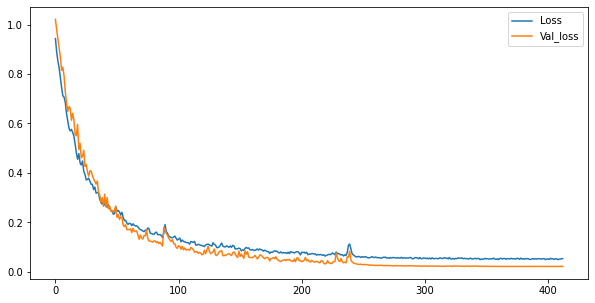

In [ ]:
print("______________ Loss plot of CAE + LSTM with 6 months as inputs and 6 as outputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
print("Best score : ", mod_6d_6f.evaluate(train6d, ytrain6d, verbose=0))

Best score :  0.01566353812813759


In [ ]:
predictions = mod_6d_6f.predict(val_6d)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval6d.shape)

Shape of the predictions set:  (131, 6, 15)
Shape of the original test set:  (131, 6, 15)


In [ ]:
pred_train = mod_6d_6f.predict(train6d)

relative_mse_train_nw =[np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train,ytrain6d)]
relative_mse_train_ow = np.linalg.norm(ytrain6d - pred_train) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain6d.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round(422.17, 2), 's')

relative_mse_test_nw =[np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(predictions,yval6d)]
relative_mse_test_ow = np.linalg.norm(yval6d - predictions) / (112*192)
mse_test = mean_squared_error(predictions.ravel(), yval6d.ravel())
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))

___________Training set predictions______________
mse for train dataset:  5.260725686584882e-05

 Time to train AE:  422.17 s

___________Testing set predictions______________
mse for test dataset:  6.32417351274908e-05


In [ ]:
results_LSTM_6to6 = {'Time for training (s)':  422.17, 
           'relative mse_test':  np.mean(relative_mse_test_nw), 
           'relative mse_train': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  np.mean(relative_mse_test_ow), 
           'relative mse_train old way': np.mean(relative_mse_train_ow),#
           'mse_test':  mse_test, 
           'mse_train': mse_train,
          }

In [ ]:
# Saving the model
# mod_6d_6f.save('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_6to6.h5')

# Load model
mod_6d_6f = load_model('/content/drive/MyDrive/Wildfires_IRP/model/CAE_LSTM/CAE_LSTM_6to6.h5')

#### Results of those models for iterative predictions on p4. 

*Since then they have been deleted because of storage capacity limits.*

In [ ]:
results_CAE_LSTM_3to1 = {'Time for predictions (s)': 44.12,
 'mse_test': 5.9017713603653374e-06,
 'relative mse new way': 1.505542135648024e-05,
 'relative mse old way': 0.0001283237935192213}

In [ ]:
results_CAE_LSTM_12to1 = {'Time for predictions (s)': 44.12,
 'mse_test': 6.147714083432566e-06,
 'relative mse new way': 1.5380413417791735e-05,
 'relative mse old way': 0.0001309703023546356}

In [ ]:
results_CAE_LSTM_6to1 = {'Time for predictions (s)': 44.12,
 'mse_test': 5.981754423827812e-06,
 'relative mse new way': 1.5331097827661068e-05,
 'relative mse old way': 0.0001291904137810308}